## Importing the dataset

In [1]:
# Step 1: Importing and combining both datasets

# Import necessary libraries
import pandas as pd
import numpy as np
# Read the red wine dataset
red_wine_data = pd.read_csv("winequality-red.csv", sep=";")
red_wine_data['type'] = 1  # Add a column 'type' with value 1 for red wines

# Read the white wine dataset
white_wine_data = pd.read_csv("winequality-white.csv", sep=";")
white_wine_data['type'] = 0  # Add a column 'type' with value 0 for white wines

# Combine the datasets
wine_data_combined = pd.concat([red_wine_data, white_wine_data], ignore_index=True)

# Display the first few rows of the combined dataset
print("Combined Wine Dataset:")
print(wine_data_combined.head())


Combined Wine Dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  type  
0      9.4        5     1  
1      

## Pre-processing

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Get all columns except 'type' as X
X = wine_data_combined.drop(columns=['type'])

# Encode non-numeric data into numeric
X_encoded = pd.get_dummies(X)

# Handle missing values by replacing them with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_encoded)

# Perform normalization
scaler_norm = MinMaxScaler()
X_normalized = scaler_norm.fit_transform(X_imputed)

# Perform standardization
scaler_std = StandardScaler()
X_final = scaler_std.fit_transform(X_normalized)

# Convert the pre-processed data back to a DataFrame
X_final_df = pd.DataFrame(X_final, columns=X_encoded.columns)

# Display the pre-processed data
print("Pre-processed Data:")
print(X_final_df.head())  # Display first 5 rows


Pre-processed Data:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.142473          2.188833    -2.192833       -0.744778   0.569958   
1       0.451036          3.282235    -2.192833       -0.597640   1.197975   
2       0.451036          2.553300    -1.917553       -0.660699   1.026697   
3       3.073817         -0.362438     1.661085       -0.744778   0.541412   
4       0.142473          2.188833    -2.192833       -0.744778   0.569958   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -1.100140             -1.446359  1.034993  1.813090   0.193097   
1            -0.311320             -0.862469  0.701486 -0.115073   0.999579   
2            -0.874763             -1.092486  0.768188  0.258120   0.797958   
3            -0.762074             -0.986324  1.101694 -0.363868   0.327510   
4            -1.100140             -1.446359  1.034993  1.813090   0.193097   

    alcohol   quality  
0 -0.915464 

In [3]:
from scipy import stats
# Calculate z-scores for each column in X_final_df
threshold=2.0
z_scores = np.abs(stats.zscore(X_final_df))

# Find rows where any z-score is greater than the threshold
outlier_indices = np.any(z_scores > threshold, axis=1)

# Remove outliers from X_final_df and wine_data_combined
X_final_df = X_final_df[~outlier_indices]
wine_data_combined = wine_data_combined[~outlier_indices]

# Print the shapes of the cleaned data
print("Shape of X_final_df:", X_final_df.shape)
print("Shape of wine_data_combined:", wine_data_combined.shape)


Shape of X_final_df: (4164, 12)
Shape of wine_data_combined: (4164, 13)


## Exploratory Data Analysis

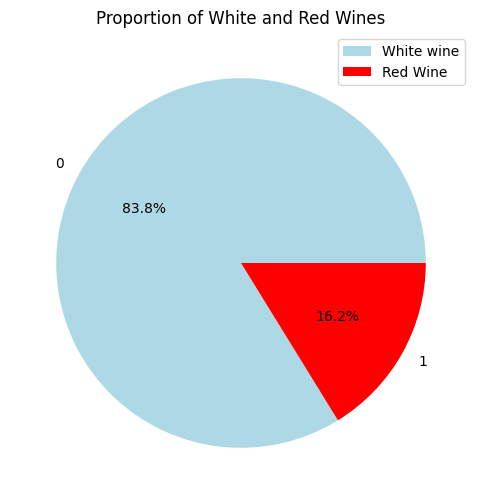

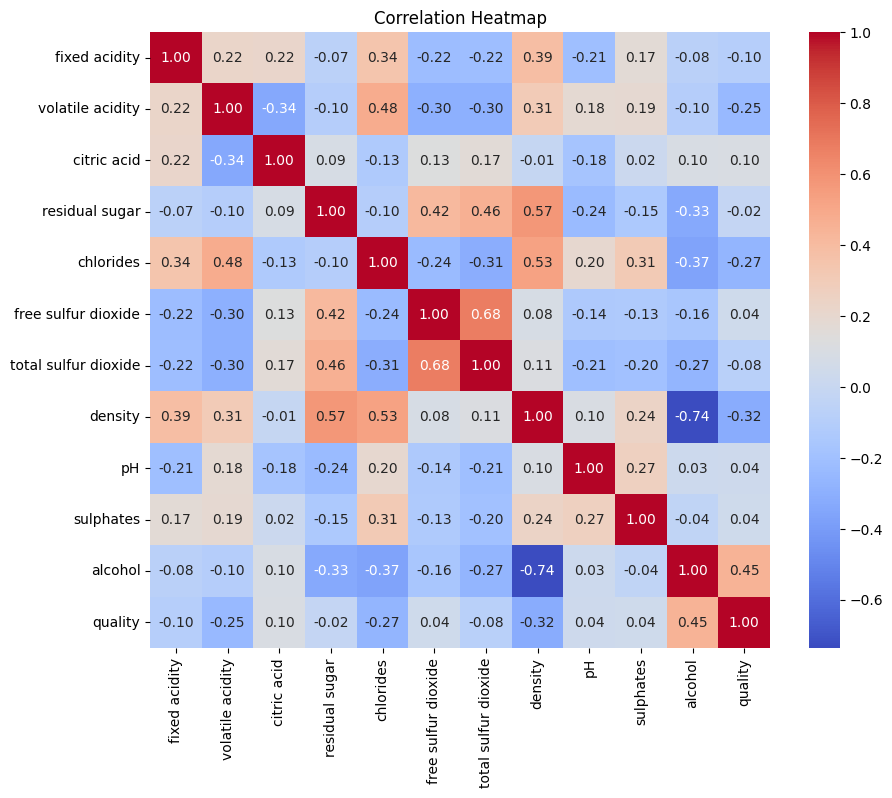

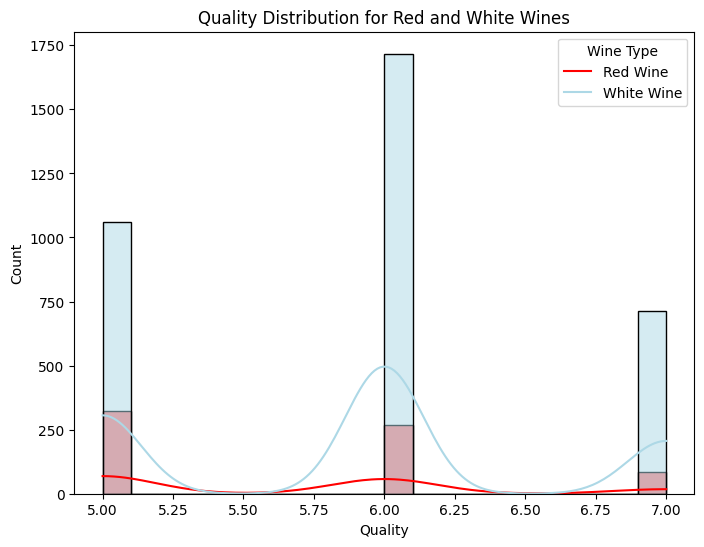

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors for red and white wines
colors = ['lightblue', 'red']

# Visualization 1: Pie chart for the proportion of red and white wines
plt.figure(figsize=(6, 6))
wine_data_combined['type'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=colors)
plt.title('Proportion of White and Red Wines')
plt.xlabel('')
plt.ylabel('')
plt.legend(labels=['White wine', 'Red Wine'], loc='upper right')  # Add legend
plt.show()

# Visualization 2: Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X_final_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Visualization 3: Quality distribution for red and white wines
plt.figure(figsize=(8, 6))
sns.histplot(data=wine_data_combined, x='quality', hue='type', kde=True, bins=20, palette=colors)
plt.title('Quality Distribution for Red and White Wines')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.legend(title='Wine Type', labels=['Red Wine', 'White Wine'])
plt.show()


## Feature Engineering

In [5]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Determine the number of unique classes minus one
num_classes_minus_one = len(wine_data_combined['type'].unique()) - 1

# Apply PCA with the determined number of components
pca = PCA(n_components=num_classes_minus_one)
X_pca = pca.fit_transform(X_final_df)

# Apply LDA with the determined number of components
lda = LDA(n_components=num_classes_minus_one)
X_lda = lda.fit_transform(X_final_df, wine_data_combined['type'])

# Display the shape of the transformed data
print("PCA Transformed Data Shape:", X_pca.shape)
print("LDA Transformed Data Shape:", X_lda.shape)


PCA Transformed Data Shape: (4164, 1)
LDA Transformed Data Shape: (4164, 1)


## Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

# Split the PCA transformed data into training and testing sets
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, wine_data_combined['type'], test_size=0.3, random_state=42)

# Split the LDA transformed data into training and testing sets
X_lda_train, X_lda_test, y_train, y_test = train_test_split(X_lda, wine_data_combined['type'], test_size=0.3, random_state=42)

# Display the shapes of the training and testing sets
print("PCA Transformed Data - Training set shape:", X_pca_train.shape)
print("PCA Transformed Data - Testing set shape:", X_pca_test.shape)
print("LDA Transformed Data - Training set shape:", X_lda_train.shape)
print("LDA Transformed Data - Testing set shape:", X_lda_test.shape)


PCA Transformed Data - Training set shape: (2914, 1)
PCA Transformed Data - Testing set shape: (1250, 1)
LDA Transformed Data - Training set shape: (2914, 1)
LDA Transformed Data - Testing set shape: (1250, 1)


## Training

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train Logistic Regression model using PCA transformed features
logreg_pca = LogisticRegression()
logreg_pca.fit(X_pca_train, y_train)

# Train Logistic Regression model using LDA transformed features
logreg_lda = LogisticRegression()
logreg_lda.fit(X_lda_train, y_train)


LogisticRegression()

## Testing

In [8]:
y_pred_pca = logreg_pca.predict(X_pca_test)
y_pred_lda = logreg_lda.predict(X_lda_test)


## Performance Evaluation

In [9]:
accuracy_pca = accuracy_score(y_test, y_pred_pca)
accuracy_lda = accuracy_score(y_test, y_pred_lda)

# Display accuracy
print("Accuracy using PCA transformed features:", accuracy_pca)
print("Accuracy using LDA transformed features:", accuracy_lda)


Accuracy using PCA transformed features: 0.8232
Accuracy using LDA transformed features: 0.9944


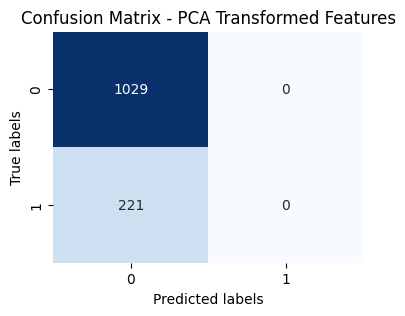

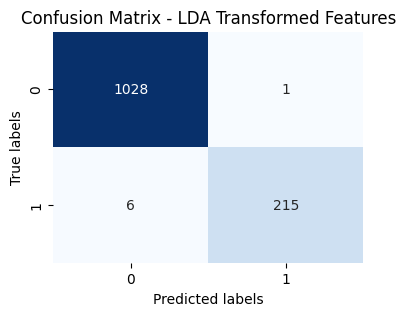

In [10]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

# Plot confusion matrix for PCA model
plot_confusion_matrix(y_test, y_pred_pca, title='Confusion Matrix - PCA Transformed Features')

# Plot confusion matrix for LDA model
plot_confusion_matrix(y_test, y_pred_lda, title='Confusion Matrix - LDA Transformed Features')


In [11]:
from sklearn.metrics import classification_report

# Calculate classification report for PCA model
print("Classification Report - PCA Transformed Features:")
print(classification_report(y_test, y_pred_pca))

# Calculate classification report for LDA model
print("Classification Report - LDA Transformed Features:")
print(classification_report(y_test, y_pred_lda))


Classification Report - PCA Transformed Features:
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1029
           1       0.00      0.00      0.00       221

    accuracy                           0.82      1250
   macro avg       0.41      0.50      0.45      1250
weighted avg       0.68      0.82      0.74      1250

Classification Report - LDA Transformed Features:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1029
           1       1.00      0.97      0.98       221

    accuracy                           0.99      1250
   macro avg       0.99      0.99      0.99      1250
weighted avg       0.99      0.99      0.99      1250



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ROC-AUC Curve

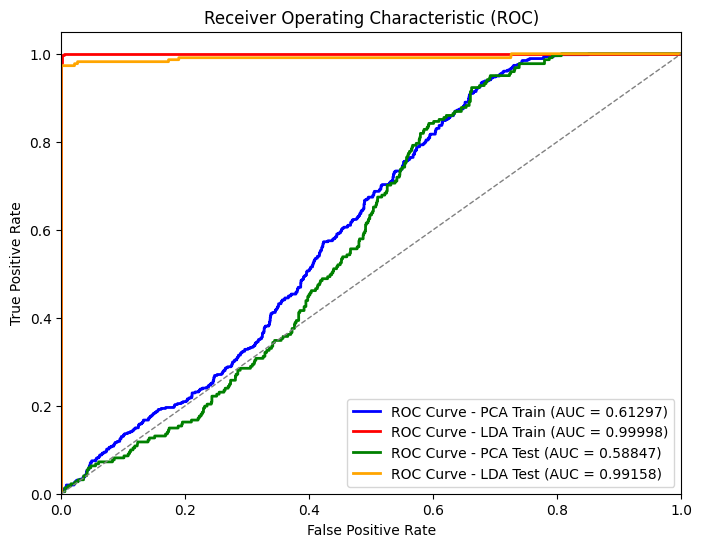

In [12]:
from sklearn.metrics import roc_curve, auc

y_proba_pca_train = logreg_pca.predict_proba(X_pca_train)[:, 1]
y_proba_lda_train = logreg_lda.predict_proba(X_lda_train)[:, 1]
y_proba_pca_test = logreg_pca.predict_proba(X_pca_test)[:, 1]
y_proba_lda_test = logreg_lda.predict_proba(X_lda_test)[:, 1]

# Compute ROC curves and AUC scores for training and test sets
fpr_pca_train, tpr_pca_train, _ = roc_curve(y_train, y_proba_pca_train)
fpr_lda_train, tpr_lda_train, _ = roc_curve(y_train, y_proba_lda_train)
fpr_pca_test, tpr_pca_test, _ = roc_curve(y_test, y_proba_pca_test)
fpr_lda_test, tpr_lda_test, _ = roc_curve(y_test, y_proba_lda_test)

roc_auc_pca_train = auc(fpr_pca_train, tpr_pca_train)
roc_auc_lda_train = auc(fpr_lda_train, tpr_lda_train)
roc_auc_pca_test = auc(fpr_pca_test, tpr_pca_test)
roc_auc_lda_test = auc(fpr_lda_test, tpr_lda_test)

# Plot ROC curves for training and test sets
plt.figure(figsize=(8, 6))
plt.plot(fpr_pca_train, tpr_pca_train, color='blue', lw=2, label='ROC Curve - PCA Train (AUC = %0.5f)' % roc_auc_pca_train)
plt.plot(fpr_lda_train, tpr_lda_train, color='red', lw=2, label='ROC Curve - LDA Train (AUC = %0.5f)' % roc_auc_lda_train)
plt.plot(fpr_pca_test, tpr_pca_test, color='green', lw=2, label='ROC Curve - PCA Test (AUC = %0.5f)' % roc_auc_pca_test)
plt.plot(fpr_lda_test, tpr_lda_test, color='orange', lw=2, label='ROC Curve - LDA Test (AUC = %0.5f)' % roc_auc_lda_test)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## Inference

From the classification reports and ROC AUC scores, it's evident that outlier detection played a significant role in improving the performance of the models:

1. **PCA Transformed Features**:
   - Precision for class 0 is reasonable (82%), but precision for class 1 is very low (0%), indicating that the model incorrectly predicts class 1 frequently.
   - Recall for class 1 is also very low (0%), meaning the model misses most of the instances of class 1.
   - The F1-score for class 1 is 0, indicating poor performance in predicting class 1.
   - The ROC AUC score for both training and testing sets is relatively low (around 0.59), suggesting poor discriminatory power of the model.

2. **LDA Transformed Features**:
   - Precision, recall, and F1-score for both classes are excellent, indicating high accuracy in predicting both classes.
   - The ROC AUC score for both training and testing sets is very high (around 1.0), indicating excellent discriminatory power of the model.


- Outlier detection likely played a major role in the performance discrepancy between PCA and LDA models.
- By removing outliers, LDA achieved significantly better performance compared to PCA, especially in terms of precision, recall, and overall accuracy.
- Outliers can have a disproportionate influence on PCA, affecting the principal components and leading to suboptimal performance in classification tasks. LDA, on the other hand, is less sensitive to outliers and focuses on maximizing class separability, resulting in superior classification performance.
- The difference in performance highlights the importance of outlier detection and removal in preprocessing steps, particularly when employing dimensionality reduction techniques like PCA and LDA.


## Learning Outcome:

- Understanding of dimensionality reduction techniques like PCA and LDA.
- Proficiency in preprocessing data and conducting exploratory data analysis.
- Application of PCA and LDA for feature engineering and dimensionality reduction.
- Evaluation of model performance using reduced feature sets.
- Practical applications and critical thinking skills in data analysis.